In [1]:
# Cell-1: Calibration: mtx, dist
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

CALIBRATE = False
# Load calibration and perspective
npzfile = np.load('calibration_n_perspective.npz')
mtx  = npzfile['mtx']
dist = npzfile['dist']
M    = npzfile['M']

if CALIBRATE:
    nx = 9
    ny = 6
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob( './camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                           (img.shape[1], img.shape[0]), None,None)


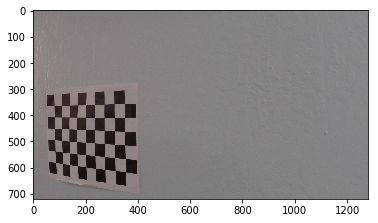

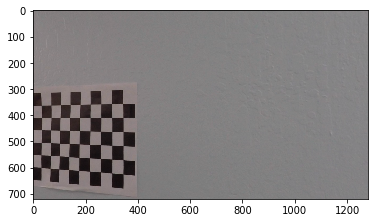

In [2]:
# Cell-2: Plot the undistorted image
img = cv2.imread('./camera_cal/calibration20.jpg')
plt.imshow(img)
plt.show()
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
plt.show()

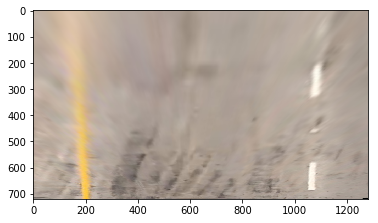

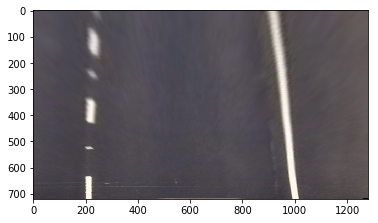

In [3]:
# Cell-3: Perspective transform matrix: M
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pt1 = [590, 450]
pt2 = [700, 450]
pt3 = [1040, 678]
pt4 = [265, 678]

src = np.float32([pt1, pt2, pt3, pt4])

pt1 = [200, 0]
pt2 = [1000, 0]
pt3 = [1000, 720]
pt4 = [200, 720]
dst = np.float32([pt1, pt2, pt3, pt4])


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

img = mpimg.imread('./test_images/video_images10orig.jpg')
fname = './test_images/straight_lines1_Warped.jpg'
undist = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)
plt.show()

img = mpimg.imread('./test_images/straight_lines2.jpg')
fname = './test_images/straight_lines2_Warped.jpg'
undist = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(undist, M, img_size)
mpimg.imsave('./warped_image_out/test1.jpg', warped, format='jpg')
plt.imshow(warped)
plt.show()
np.savez('calibration_n_perspective', mtx = mtx, dist = dist, M = M)

In [4]:
'''Cell-4: Helper functions
1. abs_sobel_thresh
2. mag_thresh
3. dir_threshold
4. hls_select
5. rgb_select
6. get_binary_image
7. Line class
    - set_curvature
    - set_car_offset
    - sanity_check [later]   
    - find_lane_pixels
    - update_lanes
    - display_lanes
'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#1. Try left center and right options for estimated lane zone from previous frame with narrow zone
#2. Think of using differenece in poly coeff between frames in sanity_check function
#2. If the sanity_check is passed average the left and right lane coefficients
#3. double check the mpx_x value by printing couple of images


# meters per pixel in X-direction    
mpx_x = 3.8/800
# meters per pixel in Y-direction    
mpx_y = 30/720

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255), nchannels = 1):
    # Convert to grayscale if the image is color
    if nchannels == 3:
        image   = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel       = np.absolute(sobel)    
    scaled_sobel    = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary     = np.zeros_like(scaled_sobel)
    grad_binary[(thresh[0] <= scaled_sobel) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255), nchannels = 1):
    # Convert to grayscale if the image is color
    if nchannels == 3:
        image   = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel       = np.sqrt(np.square(sobelx) + np.square(sobely))    
    scaled_sobel    = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    mag_binary  = np.zeros_like(scaled_sobel)
    mag_binary[(mag_thresh[0] <= scaled_sobel) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2), nchannels = 1):
    # Convert to grayscale if the image is color
    if nchannels == 3:
        image   = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    abs_sobelx = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    
    grad_direction  = np.arctan2(abs_sobely, abs_sobelx)  
    dir_binary      = np.zeros_like(grad_direction)
    dir_binary[(thresh[0] <= grad_direction) & (grad_direction <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255), channel = 's'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        C = hls[:,:,0]
    if channel == 'l':    
        C = hls[:,:,1]
    if channel == 's':
        C = hls[:,:,2]

    binary_output = np.zeros_like(C) 
    binary_output[(thresh[0] < C) & (C <= thresh[1])] = 1
    return binary_output

def rgb_select(img, thresh=(0, 255), channel = 'r'):
    if channel == 'r':
        C = img[:,:,0]
    if channel == 'g':    
        C = img[:,:,1]
    if channel == 'b':
        C = img[:,:,2]

    binary_output = np.zeros_like(C) 
    binary_output[(thresh[0] < C) & (C <= thresh[1])] = 1
    return binary_output    

def get_binary_image(img):
    image = cv2.undistort(img, mtx, dist, None, mtx)
    kernel_size_gradxy_mag = 7
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size_gradxy_mag, thresh=(20, 100), nchannels = 3)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=kernel_size_gradxy_mag, thresh=(30, 100), nchannels = 3)
    mag_binary = mag_thresh(image, sobel_kernel=kernel_size_gradxy_mag, mag_thresh=(30, 255), nchannels = 3)
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0, 1.4), nchannels = 3)
    s_binary = hls_select(image, thresh=(200, 255), channel = 's')
    r_binary = rgb_select(image, thresh=(220, 255), channel = 'r')
    

    # Combine various binaries 
    combined_binary = np.zeros_like(image[:,:,0])
    combined_binary[gradx == 1] = 1
    combined_binary[grady == 1] = 1
    combined_binary[mag_binary == 0] = 0    
    combined_binary[dir_binary == 0] = 0
    combined_binary[r_binary == 1] = 1
    combined_binary[s_binary == 1] = 1      
    return combined_binary   

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, side):
        self.side = side
        # was the line detected in the last iteration?
        self.detected = False  
        self.nFailedFrames = 0  
        self.nresetFrames = 0
        self.pixels_count = np.zeros([1,3])
        # confidence in percentage of range over which search the x-values in hist
        # self.confidence = 0
        # x values of the last n = 5 fits of the line
        # Sam: we only have x-values, y-values are not same in different frames
        #self.recent_xfitted = [] 
        #average x values of the fitted line over the last n = 5 iterations
        # Sam: we only have x-values, y-values are not same in different frames
        #self.bestx = None     
        #polynomial coefficients averaged over the last n = 5 iterations
        self.best_fit = None        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None

    def update_curvature(self):
        # computes and updates the curvature for best fit
        # change it from pixels to meters
        a, b, c = self.best_fit
        a = a*mpx_x/(mpx_y**2)
        b = b*mpx_x/mpx_y
        self.radius_of_curvature = ((1 + (2*a*30 + b)**2)**1.5) / np.absolute(2*a)

    def set_detected(self):
        # Good lane detected
        self.detected = True
        self.nFailedFrames = 0

    def updateCounter(self):
        self.nFailedFrames += 1
        if self.nFailedFrames > 10:
            self.detected = False
            self.nFailedFrames = 0
        
    def reset_detected(self):
        # computes and updates the curvature for current fit
        self.detected = False
        
    def update_best_fit(self):
        self.best_fit = self.best_fit*0.7 + 0.3*self.current_fit

    def update_lane_line(self, binary_image, alg = 'alg1'):            
        
        #******************************************************************************
        # Set the hyper parameters and initialization
        #******************************************************************************
        FIT2WICE = True
        filter_width = 1
        window_filter = np.ones(filter_width)    
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50        
        # Choose the number of sliding windows for finding pixels
        nwindows = 9
        binary_warped = cv2.warpPerspective(binary_image, M, (binary_image.shape[1], binary_image.shape[0]), flags=cv2.INTER_NEAREST)  # keep same size as input image            
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #******************************************************************************
        
        if self.detected:
            # If previous lane was detected with great confidence
            margin = 30
            off_margin = 30
            lane_fit = self.best_fit
            lane_inds = ((nonzerox > (lane_fit[0]*(nonzeroy**2) + lane_fit[1]*nonzeroy + 
            lane_fit[2] - margin)) & (nonzerox < (lane_fit[0]*(nonzeroy**2) + 
            lane_fit[1]*nonzeroy + lane_fit[2] + margin)))

            # Again, extract lane pixel positions
            lanex_c = nonzerox[lane_inds]
            laney_c = nonzeroy[lane_inds] 
            n_pixels_c = len(lanex_c)
            n_pixels_max = n_pixels_c
            lanex = lanex_c
            laney = laney_c            



            lane_inds = ((nonzerox > (lane_fit[0]*(nonzeroy**2) + lane_fit[1]*nonzeroy + 
            lane_fit[2] - margin - off_margin)) & (nonzerox < (lane_fit[0]*(nonzeroy**2) + 
            lane_fit[1]*nonzeroy + lane_fit[2] + margin - off_margin)))

            # Again, extract lane pixel positions
            lanex_l = nonzerox[lane_inds]
            laney_l = nonzeroy[lane_inds] 
            n_pixels_l = len(lanex_l)

            if n_pixels_l  > n_pixels_max:
                n_pixels_max = n_pixels_l
                lanex = lanex_l
                laney = laney_l            

            lane_inds = ((nonzerox > (lane_fit[0]*(nonzeroy**2) + lane_fit[1]*nonzeroy + 
            lane_fit[2] - margin + off_margin)) & (nonzerox < (lane_fit[0]*(nonzeroy**2) + 
            lane_fit[1]*nonzeroy + lane_fit[2] + margin + off_margin)))

            # Again, extract lane pixel positions
            lanex_r = nonzerox[lane_inds]
            laney_r = nonzeroy[lane_inds] 
            n_pixels_r = len(lanex_r)

            if n_pixels_r  > n_pixels_max:
                n_pixels_max = n_pixels_r
                lanex = lanex_r
                laney = laney_r            


            self.pixels_count = np.array([n_pixels_l, n_pixels_c, n_pixels_r])
        else:
            # [sam] Instead of argmax over all the range. This can be modified to look around some estimate from history
            # maintaining history needs to be thought.            
            # Take a histogram of the bottom half of the image
            if self.best_fit is None:                    
                # If this is first frame start from scratch
                if self.side == 'left':
                    l_sum   = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:int(binary_warped.shape[1]/2)], axis=0)
                    x_base  = np.argmax(np.convolve(window_filter,l_sum))-filter_width/2
                else:
                    r_sum   = np.sum(binary_warped[int(binary_warped.shape[0]/2):,int(binary_warped.shape[1]/2):], axis=0)
                    x_base  = np.argmax(np.convolve(window_filter,r_sum))-filter_width/2 + int(binary_warped.shape[1]/2)
            else:
                # if this is 2nd attempt since sanity failed with using polynomial as ROI
                # Just use the base x position based on previous frame
                a, b, c = self.best_fit
                y = 720
                x_base = (a*(y**2) + b*y + c)
                
            # Current positions to be updated for each window
            x_current = x_base
            # Create empty list to receive lane pixel indices
            lane_inds = []           

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low   = binary_warped.shape[0] - (window+1)*window_height
                win_y_high  = binary_warped.shape[0] - window*window_height
                win_x_low   = x_current - margin
                win_x_high  = x_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_lane_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
                # Append these indices to the lists
                lane_inds.append(good_lane_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_lane_inds) > minpix:
                    x_current = np.int(np.mean(nonzerox[good_lane_inds]))
            # Concatenate the arrays of indices
            lane_inds  = np.concatenate(lane_inds)

            # Extract left and right line pixel positions
            lanex = nonzerox[lane_inds]
            laney = nonzeroy[lane_inds] 

        # Fit a second order polynomial to each
        lane_fit = np.polyfit(laney, lanex, 2)

        
        if FIT2WICE:
            margin1 = 50
            lane_inds = ((nonzerox > (lane_fit[0]*(nonzeroy**2) + lane_fit[1]*nonzeroy + 
            lane_fit[2] - margin1)) & (nonzerox < (lane_fit[0]*(nonzeroy**2) + 
            lane_fit[1]*nonzeroy + lane_fit[2] + margin1)))

            # Again, extract lane pixel positions
            lanex = nonzerox[lane_inds]
            laney = nonzeroy[lane_inds] 

        # Fit a second order polynomial to each
        self.current_fit = np.polyfit(laney, lanex, 2)
        if self.best_fit is None:
            self.best_fit = self.current_fit
        return

def sanity_check(left_lane, right_lane, firstAttempt = True):    
    sanity_flag = True
    # compute lane width in meters for current fit
    la, lb, lc = left_lane.current_fit
    ra, rb, rc = right_lane.current_fit
    y = np.linspace(0, 720, 121)
    left_lane_pts = (la*(y**2) + lb*y + lc)
    right_lane_pts = (ra*(y**2) + rb*y + rc)
    diff = np.absolute(left_lane_pts-right_lane_pts)
    # lane width in meters
    lane_width = np.mean(diff)*mpx_x
    
    # Check if lanes are almost parallel
    if (np.max(diff)/np.min(diff)) > 1.5:
        if firstAttempt:
            return False
        else:
            sanity_flag = False    
            
            
    if sanity_flag:
        # Adds to the history of fits
        # sets the detected flag
        left_lane.update_best_fit()
        left_lane.set_detected()
        right_lane.update_best_fit()
        right_lane.set_detected()
    else:
        #increase failed frame counter
        left_lane.updateCounter()
        right_lane.updateCounter()        
        if left_lane.nFailedFrames == 0:
            left_lane.nresetFrames += 1
            print("reset = ", left_lane.nresetFrames)
        
def display_lanes(image, left_lane, right_lane, style = 'orig'):
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    color_warp = np.zeros_like(image)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    if style == 'orig':
        unwarped_image = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
        result = cv2.addWeighted(image, 1, unwarped_image, 0.3, 0) 
    else:
        unwarped_image = color_warp
        image  = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
        result = cv2.addWeighted(image, 1, unwarped_image, 0.3, 0)     
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText1 = (100,50)
    bottomLeftCornerOfText2 = (100,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    
    # compute the lane curvature and offset from center
    right_lane.update_curvature()
    radius = np.round(right_lane.radius_of_curvature*100)/100
    # compute lane offset from center of image
    la, lb, lc = left_lane.best_fit
    ra, rb, rc = right_lane.best_fit
    y = np.linspace(0, 720, 121)
    left_lane_pts = (la*(y**2) + lb*y + lc)
    right_lane_pts = (ra*(y**2) + rb*y + rc)
    lane_width_pixels = np.absolute(right_lane_pts-left_lane_pts)
    lane_array_str = str(np.array([np.max(lane_width_pixels)/np.min(lane_width_pixels), np.max(lane_width_pixels)/np.mean(lane_width_pixels), np.mean(lane_width_pixels)/np.min(lane_width_pixels)]))
    
    lane_center = left_lane_pts[-1] + lane_width_pixels[-1]/2
    offset_pixels = np.absolute(1280/2-lane_center)
    offset_meters = np.round(offset_pixels*mpx_x*100)/100

    if offset_meters < 0:
        offset_str = "Vehicle is " + str(np.absolute(offset_meters)) + " m right of the center"
    else:
        offset_str = "Vehicle is " + str(offset_meters) + " m left of the center"
     
    
    cv2.putText(result,'Radius of curvature = ' + str(radius) + " m ", 
        bottomLeftCornerOfText1, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(result,lane_array_str, 
        bottomLeftCornerOfText2, 
        font, 
        fontScale,
        fontColor,
        lineType)

    
    
    return result


In [5]:
# Debugging: image processing
DEBUG = False
if DEBUG:
    fimages = './video_image_in/video_images'
    #fimages = './test_images/straight_lines'
    #fimages = './test_images/test_utsaw'
    left_lane = Line('left')
    right_lane = Line('right')
    image_counter = 12
    #image_counter = 1
    # Step through the list and search for chessboard corners
    for idx in range(1):
        fname = fimages + str(image_counter) + 'orig.jpg'
        print(fname)
        image   = mpimg.imread(fname)
        combined_binary = get_binary_image(image)
        combined_binary_color = np.zeros_like(image)
        combined_binary_color[combined_binary > 0 ,0] = 255
        combined_binary_color[combined_binary > 0 ,1] = 255
        combined_binary_color[combined_binary > 0 ,2] = 255
        # First attempt
        left_lane.update_lane_line(combined_binary)
        right_lane.update_lane_line(combined_binary)
        check = sanity_check(left_lane, right_lane)
        '''
        if not check:
            print('trying second attempt')
            # Try Second attempt with resetting the detection flag
            left_lane.reset_detected()
            left_lane.update_lane_line(combined_binary)
            right_lane.reset_detected()
            right_lane.update_lane_line(combined_binary)
            check = sanity_check(left_lane, right_lane, firstAttempt = False)
        '''
        out_img = display_lanes(image, left_lane, right_lane)
        #out_img = display_lanes(image, left_lane.current_fit, right_lane.current_fit)
        #out_img = cv2.warpPerspective(out_img, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
        mpimg.imsave('./video_image_out/video_images'+str(image_counter) + '.jpg', out_img, format='jpg')
        out_img = np.zeros_like(out_img)
        out_img[np.absolute(combined_binary) > 0,2] = 255
        #mpimg.imsave('./video_image_out/video_images_bin'+str(image_counter) + '.jpg', out_img, format='jpg')    
        combined_binary_color = cv2.warpPerspective(combined_binary_color, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
        mpimg.imsave('./video_image_out/video_images_bin_warp'+str(image_counter) + '.jpg', combined_binary_color, format='jpg')
        #image_counter += 2        
        image_counter += 1    

In [6]:
left_lane = Line('left')
right_lane = Line('right')
fname = './video_image_in/video_images'
fname_out = './video_image_out/video_images'
image_counter = 0
IMWRITE = False
# Cell-4: Main function for image processing
def process_image(image):    
    combined_binary = get_binary_image(image)
    combined_binary_color = np.zeros_like(image)
    combined_binary_color[combined_binary > 0 ,0] = 255
    combined_binary_color[combined_binary > 0 ,1] = 255
    combined_binary_color[combined_binary > 0 ,2] = 255
    
    # First attempt
    left_lane.update_lane_line(combined_binary)
    right_lane.update_lane_line(combined_binary)
    check = sanity_check(left_lane, right_lane)

    if not check:
        # Try Second attempt with resetting the detection flag
        left_lane.reset_detected()
        left_lane.update_lane_line(combined_binary)
        right_lane.reset_detected()
        right_lane.update_lane_line(combined_binary)
        check = sanity_check(left_lane, right_lane, firstAttempt = False)
    
    final_image = display_lanes(image, left_lane, right_lane)
    if IMWRITE:
        global image_counter 
        if image_counter % 1 == 0:
            #image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)            
            mpimg.imsave(fname+str(image_counter) + 'orig.jpg', image, format='jpg')
            mpimg.imsave(fname+str(image_counter) + 'detected.jpg', final_image, format='jpg')
            #mpimg.imsave(fname+str(image_counter) + 'binary.jpg', combined_binary_color, format='jpg')
            combined_binary_color = cv2.warpPerspective(combined_binary_color, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
            mpimg.imsave(fname+str(image_counter) + 'binary_warped.jpg', combined_binary_color, format='jpg')
        image_counter += 1
    return final_image

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
white_output = 'test_videos_output/project_video.mp4'
#clip1 = VideoFileClip("./project_video.mp4").subclip(25,26)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [09:30<00:00,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 19min 1s, sys: 37.4 s, total: 19min 39s
Wall time: 9min 31s


In [9]:
import numpy as np
Flag = None
x = np.zeros([1,3])
print(x.shape)
y = np.zeros(3)
print(y.shape)
y = np.array([1, 3, 4])
if Flag is not None:
    print(type(y))
else:
    print(y)

(1, 3)
(3,)
[1 3 4]
